In [1]:
!pip install rouge

In [2]:
import pandas as pd
import os
import pickle
import gensim
from gensim.models import Word2Vec
import numpy as np
import re
from sklearn.model_selection import train_test_split
import tensorflow
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from keras.utils import to_categorical, pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [3]:
def readFile(path):
    with open(path, 'r', encoding="utf-8") as f:
        text = f.read()
    return text


In [4]:
def removePunct(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r" +", " ", text)
    return text


def preProcess(data):
    temp = []
    for d in data:
        text = removePunct(d)
        temp.append(text)
    return temp


In [5]:
def getData(text):
    x = []
    y = []
    data = text.split("\n")
    for d in data:
        try:
            x_, y_ = d.split("\t")
            x.append(x_)
            y.append(y_)
        except:
            pass
    x = preProcess(x)
    y = preProcess(y)
    return [x, y]

def removeLongSentence(data_all, n):
    x_fin = []
    for idx,ele in enumerate(data_all):
        ele_split = ele.split()
        if len(ele_split) < n and len(ele_split) > 1:
            x_fin.append(ele)            
    return x_fin

In [6]:
train_data = readFile("/kaggle/input/nlp-project/train.txt")
test_data = readFile("/kaggle/input/nlp-project/dev.txt")
# ngram = 4

In [7]:
_, x_train_ori = getData(train_data)
_, x_test = getData(test_data)

In [8]:
x_train, x_val = train_test_split(x_train_ori, test_size=0.1, random_state=42)

In [9]:
max_sent_len_limit = 100
x_train_red = removeLongSentence(x_train,max_sent_len_limit)
x_val_red = removeLongSentence(x_val,max_sent_len_limit)
x_test_red = removeLongSentence(x_test,max_sent_len_limit)

In [10]:
len(x_test_red)

895

In [11]:
len(x_train_red)

6731

In [12]:
def trainTokenizeData(data_all, max_sent_len_limit):
    data_all = removeLongSentence(data_all, max_sent_len_limit)
    x_tokenizer = Tokenizer(oov_token='<UNK>', num_words=4451)
    x_tokenizer.fit_on_texts(data_all)
    x_encoded = x_tokenizer.texts_to_sequences(data_all)
    return x_encoded, x_tokenizer


def testTokenizeData(data_all, x_tokenizer, max_sent_len_limit):
    data_all = removeLongSentence(data_all, max_sent_len_limit)
    x_encoded = x_tokenizer.texts_to_sequences(data_all)
    return x_encoded


In [13]:
x_train_seq, train_tokenizer = trainTokenizeData(x_train_red, max_sent_len_limit)
x_dev_seq = testTokenizeData(x_val_red, train_tokenizer, max_sent_len_limit)
x_test_seq = testTokenizeData(x_test_red, train_tokenizer, max_sent_len_limit)


In [14]:
def getMaxLen(x_train, x_dev, x_test):
    max1 = max([len(x) for x in x_train])
    max2 = max([len(x) for x in x_dev])
    max3 = max([len(x) for x in x_test])
    return max(max1, max2, max3)


In [15]:
def splitPadSequences(X_tokenized, max_sequence_len, total_words=4451):
    input_sequences = []
    for ele in X_tokenized:
#         for i in range(len(ele)-ngram+1):
#             n_gram_sequence = ele[i:i+ngram]
#             input_sequences.append(n_gram_sequence)
        for i in range(1, len(ele)):
            n_gram_sequence = ele[:i+1]
            input_sequences.append(n_gram_sequence)

    input_sequences = np.array(input_sequences)
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = to_categorical(label, num_classes=total_words)

    return predictors, label


In [16]:
max_len = getMaxLen(x_train_seq, x_dev_seq, x_test_seq)
x_train_sp, y_train_sp = splitPadSequences(x_train_seq, max_len)
x_val_sp, y_val_sp = splitPadSequences(x_dev_seq, max_len)
x_test_sp, y_test_sp = splitPadSequences(x_test_seq, max_len)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [17]:
x_train_sp.shape

(75075, 86)

In [18]:
y_train_sp.shape

(75075, 4451)

In [19]:
x_test_sp.shape

(10499, 86)

In [20]:
y_test_sp.shape

(10499, 4451)

In [21]:
def createModel(max_seq_len, total_words, bidirectional=False, dropout = 0.2):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_seq_len-1,mask_zero=True))
    if bidirectional:
        model.add(Bidirectional(LSTM(128)))
    else:
        model.add(LSTM(128))
    model.add(Dropout(dropout))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['acc'])
    model.summary()
    print("\n")
    return model


In [22]:
def plot_loss(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [23]:
def trainModel(model, x_train, y_train, x_val, y_val, epochs=100, batch_size=128):
    # filepath = "model.h5"
    # checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
    #                              save_best_only=True, mode='min')
    early = EarlyStopping(monitor="val_loss",
                          patience=5, verbose=1)
    callbacks_list = [early]
    history = model.fit(x_train, y_train, epochs=epochs,
                        batch_size = batch_size, verbose=2, callbacks=callbacks_list, validation_data=(x_val, y_val))
    return history


In [24]:
def calculate_preplexity(dataset_line,y_pred, Y):
    val = 0
    for idx in range(len(dataset_line)-1):
        Y_idx = np.argmax(Y[idx])
        p_val = y_pred[idx][Y_idx]
        val += np.log2(p_val)
    val = -1*(val/(len(dataset_line)-1))
    return 2**val


def get_all_preplexity_scores(dataset_lines, y_pred, Y):
    preplexity_scores = []
    counter = 0
    next_counter = 0
    for idx, ele in enumerate(dataset_lines):
        next_counter += (len(ele) - 1)
        preplexity_scores.append(calculate_preplexity(
            ele, y_pred[counter:next_counter], Y[counter:next_counter]))
        counter = next_counter
    return preplexity_scores, np.mean(preplexity_scores)

def evaluate_model(model, datalines, X_test, Y_test, model_name):
    y_pred_test = model.predict(X_test)
    preplexity_scores_test, mean_score_test = get_all_preplexity_scores(
        datalines, y_pred_test, Y_test)
    y_pred_fl=np.argmax(y_pred_test, axis=1)
    y_test_fl=np.argmax(Y_test, axis=1)
    print("\n",model_name," Mean Perplexity Score is: ",mean_score_test)
    print("\nAccuracy Score:", accuracy_score(y_test_fl, y_pred_fl))
    print("\nPrecision Score:", precision_score(y_test_fl, y_pred_fl, average='macro'))
    print("\nRecall Score:", recall_score(y_test_fl, y_pred_fl, average='macro'))
    print("\nF1 Score:", f1_score(y_test_fl, y_pred_fl, average='macro'),"\n\n")
    
    all_rouge_scores, last_n_words = get_all_rouge_scores(model,x_test_red,train_tokenizer,max_len)
    plot_rouge_scores(all_rouge_scores, last_n_words)
    
#     print("\nClassification Report:\n", classification_report(y_test_fl, y_pred_fl))

In [25]:
def generate_text(seed_text, next_words, max_sequence_len, tokenizer, model):
    fin_text = ""
    for i in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = np.array(pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
        predicted = model.predict(token_list,verbose = 0)
        predicted = np.argmax(predicted)
        output_word = ""
        for index, word in tokenizer.index_word.items():
            if index == predicted:
                output_word = word
                break
        fin_text += str(output_word) + " "
        seed_text += str(output_word) + " "
    return fin_text

def list_to_string(x_list_elements):
    fin_str = ""
    for ele in x_list_elements:
        fin_str += ele + " "
    return fin_str

def get_rouge_score(model,last_n_words,x_sentences,tokenizer,max_sequence_len):
    rouge_scores = []
    rouge = Rouge()
    for idx,ele in enumerate(x_sentences):
        ele_fin = ele.split()[:-last_n_words]
        ele_short_sent = list_to_string(ele_fin)
        ele_true_token = ele.split()[-last_n_words:]
        ele_true_sent = list_to_string(ele_true_token)
        pred_sent = generate_text(ele_short_sent,last_n_words,max_sequence_len,tokenizer,model)
        scores = rouge.get_scores(pred_sent, ele_true_sent, avg=True)
        rouge_scores.append(scores['rouge-l']['f'])
    return rouge_scores

def get_all_rouge_scores(model,x_sentences,tokenizer,max_sequence_len):
    last_n_words = [3,4,5]
    all_rouge_scores = []
    for ele in last_n_words:
        r_scores = get_rouge_score(model,ele,x_test_red,train_tokenizer,max_len)
        all_rouge_scores.append(np.mean(r_scores))
        print("Rouge Scores done for last ", ele , " words")
    return all_rouge_scores, last_n_words

def plot_rouge_scores(all_rouge_scores_mean,last_n_words):
    plt.xlabel("Predicted Words")
    plt.ylabel("Rouge Scores")
    plt.title("Predicted Words vs Rouge Scores")
    # plot lines
    last_n_words = [format(x, 'd') for x in last_n_words]
    plt.bar(last_n_words, all_rouge_scores_mean,color ='b',width = 0.4)
    plt.show()

In [26]:
model_lstm = createModel(max_len, 4451)
model_lstm_hist = trainModel(model_lstm, x_train_sp, y_train_sp,
                        x_val_sp, y_val_sp, batch_size=1024)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 86, 100)           445100    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4451)              574179    
                                                                 
Total params: 1,136,527
Trainable params: 1,136,527
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
74/74 - 42s - loss: 7.2944 - acc: 0.0521 - val_loss: 6.3726 - val_acc: 0.0569 - 42s/epoch - 573ms/step
Epoch 2/100
74/74 - 29s - loss: 6.5030 - acc: 0.0532 - val_lo

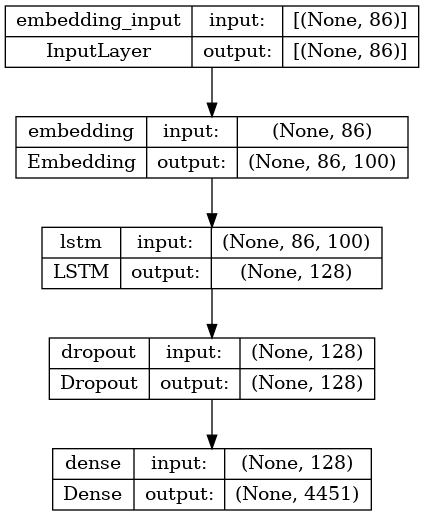

In [27]:
plot_model(model_lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

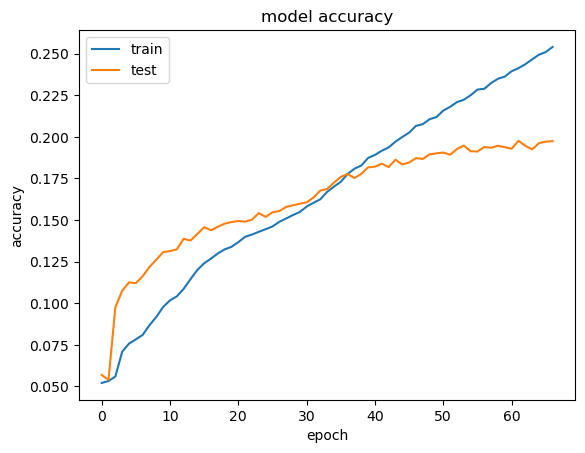

In [28]:
plot_loss(model_lstm_hist)

In [29]:
model_lstm.save("generic_gram_generation.h5")

329/329 [==============================] - 8s 19ms/step

 Generic Ngram Model  Mean Perplexity Score is:  55742.084882726216

Accuracy Score: 0.1886846366320602

Precision Score: 0.0284149732221687

Recall Score: 0.027396459450650626

F1 Score: 0.024736579157935836 




/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rouge Scores done for last  3  words
Rouge Scores done for last  4  words
Rouge Scores done for last  5  words


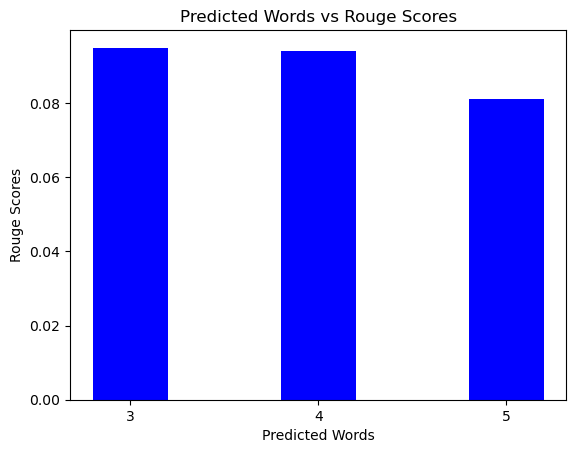

In [30]:
# model_generic = load_model('/kaggle/input/nlp-project-generation-model/generic_gram_generation.h5')
evaluate_model(model_lstm, x_test_seq, x_test_sp,y_test_sp,"Generic Ngram Model")

In [31]:
model_bilstm = createModel(max_len, 4451,bidirectional=True)
model_bilstm_hist = trainModel(model_bilstm, x_train_sp, y_train_sp,
                        x_val_sp, y_val_sp, batch_size=1024)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 86, 100)           445100    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4451)              1143907   
                                                                 
Total params: 1,823,503
Trainable params: 1,823,503
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
74/74 - 57s - loss: 7.2206 - acc: 0.0520 - val_loss: 6.3187 - val_acc: 0.0966 - 57s/epoch - 775m

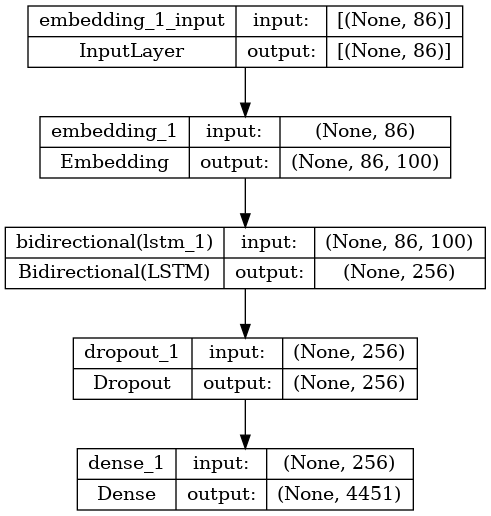

In [32]:
plot_model(model_bilstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

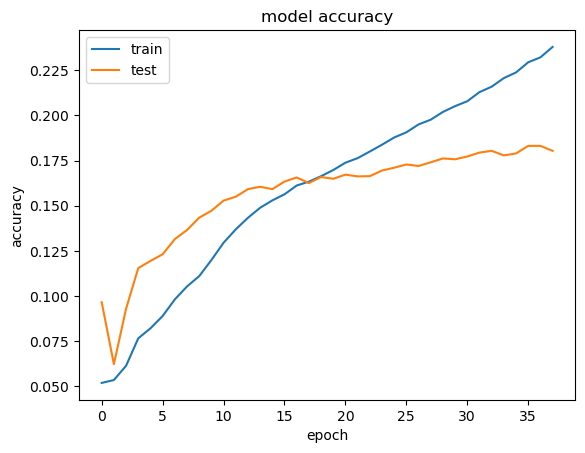

In [33]:
plot_loss(model_bilstm_hist)

In [34]:
model_bilstm.save("generic_gram_biLSTM_generation.h5")

329/329 [==============================] - 21s 56ms/step

 Generic Ngram Model Bi-LSTM  Mean Perplexity Score is:  26767.70570068856

Accuracy Score: 0.17287360701019144

Precision Score: 0.020960321342494863

Recall Score: 0.020913265321401666

F1 Score: 0.01764628871882291 




/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rouge Scores done for last  3  words
Rouge Scores done for last  4  words
Rouge Scores done for last  5  words


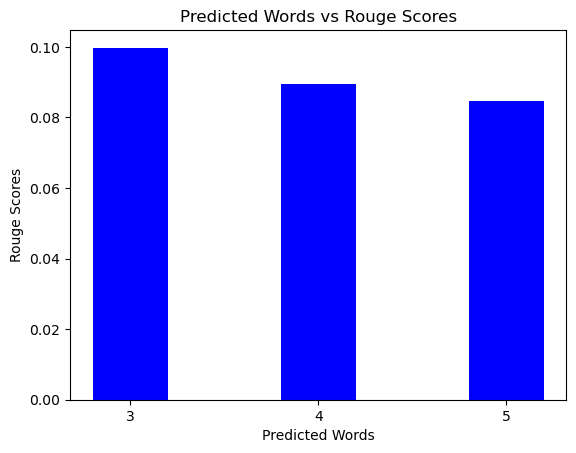

In [35]:
# model_generic_bi = load_model('/kaggle/input/nlp-project-generation-model/generic_gram_biLSTM_generation.h5')
evaluate_model(model_bilstm, x_test_seq, x_test_sp,y_test_sp,"Generic Ngram Model Bi-LSTM")

In [36]:
input_Sentence = 'hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke'
full_sentence = 'hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke liye isko dekh loonga'
output_sentence = generate_text(input_Sentence,4,max_len,train_tokenizer,model_bilstm)

In [37]:
print("\nInput Sentence: \n", input_Sentence)
print("\n\nFull Sentence: \n", full_sentence)
print("\n\nGenerated Sentence: \n",input_Sentence + " " + output_sentence)


Input Sentence: 
 hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke


Full Sentence: 
 hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke liye isko dekh loonga


Generated Sentence: 
 hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke liye tho is movie 
